In [2]:
import os
from segment_anything.build_sam import sam_model_registry
from scripts.experiments.mask_aug.inference import class_inference, load_model
from scripts.sam_train import SamTrain
from segment_anything.modeling.sam import Sam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.datasets.constant import IMAGE_TYPE
from scripts.datasets.preprocess_raw import FLARE22_Preprocess
from scripts.utils import torch_try_load
from scripts.experiments.mask_aug.inference import get_all_organ_range

%matplotlib inline

VAL_ROOT = "../dataset/FLARE22-version1/ReleaseValGT-20cases"
VOLUME_CACHE = os.path.join(VAL_ROOT, "images/FLARETs_0002_0000.cache.pt")
IMAGE_PATH = os.path.join(VAL_ROOT, "images/FLARETs_0002_0000.nii.gz")
MASK_PATH = os.path.join(VAL_ROOT, "labels/FLARETs_0002.nii.gz")
MODEL_PATH = "../runs/transfer/imp-230603-150046/model-20.pt"
# MODEL_PATH = "../runs/exps-230701-165310/model-20.pt"

model: Sam = sam_model_registry["vit_b"](
        checkpoint="../sam_vit_b_01ec64.pth", custom=MODEL_PATH
    )
sam_train = SamTrain(sam_model=model)


In [29]:
from collections import defaultdict
from typing import Callable, Dict, List, Optional, Tuple
import uuid
from uuid import UUID
from dataclasses import dataclass, field
from time import time_ns
from typing import Dict

from scripts.datasets.f22_improve import Augmentation
from scripts.experiments.beam_search.beam_search_engine import BeamSearchInferenceEngine
from scripts.experiments.mask_aug.inference import pick_best_mask
import torch
from torch import Tensor
from scipy.ndimage import gaussian_filter

preprocessor = FLARE22_Preprocess()

# @dataclass
# class BeamSearchOptionData:
#     obj_id: UUID = field(default_factory=uuid.uuid4)
#     prev_id: Optional[UUID] = None
#     sigmoid_threshold: float = 0.0
#     score: float = 0.0
#     prev_score: float = 0.0
#     frame_idx : Optional[int] = None
#     next_frame_idx: Optional[int] = None
#     mask_logits: torch.Tensor = None
#     cyclic_count: int = 0

#     def get_mask(self) -> torch.Tensor:
#         if self.prev_id is None:
#             return self.mask_logits
        
#         return torch.sigmoid(self.mask_logits) > self.sigmoid_threshold
    
# @dataclass
# class BeamSearchTracing:
#     data: BeamSearchOptionData = None
#     children: List[BeamSearchOptionData] = field(default_factory=list)

# class Tracing:
#     def __init__(self) -> None:
#         self.trace_dict: Dict[str, BeamSearchTracing] = {}
#         pass

#     def add(self, obj: BeamSearchOptionData):
#         # Register itself into the system
#         self.trace_dict[obj.obj_id] = BeamSearchTracing(data=obj)
#         # Link the current object
#         prev_data = self.trace_dict.get(obj.prev_id, None)
#         if prev_data is None: return
#         prev_data.children.append(obj)
#         pass

#     def flatten(self):
#         result = []
#         for value in self.trace_dict.values():
#             result.extend(value.children)
#         return result
    
#     def tracing(self, prev_id) -> List[BeamSearchOptionData]:
#         # Safe-guard the tracing
#         counter = 1000
#         prev = self.trace_dict[prev_id]
#         result = []
#         while prev.data.prev_id is not None and counter > 0:
#             result.append(prev.data)
#             prev = self.trace_dict[prev.data.prev_id]
#             counter = counter - 1
#             pass
#         return result

# def make_gauss_point_mask(x, y, shape=(512, 512), radius=3, gaussian_config=None):
#     result = np.zeros(shape)
#     xmax = min(x + radius, shape[0])
#     ymax = min(y + radius, shape[1])
#     xmin = max(x - radius, 0)
#     ymin = max(y - radius, 0)
#     result[ymin:ymax, xmin:xmax] = 1.0

#     if gaussian_config:
#         result = gaussian_filter(result, sigma=gaussian_config['sigma'])
#         result = (result - np.min(result)) / (np.max(result) - np.min(result))
    
#     result = torch.as_tensor(result)
#     return result

# def make_centroid(input_masks, local_mean_centroid: np.ndarray, is_input_reversed=False):
#     # `is_input_reversed: bool`: it's proven that reversed input have more consistent feature.
#     # Therefore, our feature is compute on reversed input. If the input is not reversed,
#     # set `is_input_reversed=True` so it will be done for you

#     if not is_input_reversed:
#         masks = input_masks[::-1]
#     else:
#         masks = input_masks

#     starts, ends = get_all_organ_range(masks)
#     starts = np.nan_to_num(starts.astype(np.float32), nan=0.0)
#     ends = np.nan_to_num(ends.astype(np.float32), nan=0.0)
#     dur = ends - starts
#     dur: np.ndarray = np.pad(
#         np.reshape(dur, [-1, 1]), 
#         pad_width=[(0, 0), (0, 2)], 
#         constant_values=512
#     )
#     # Take the centroid in z-axis of local organ, and then add back the starts
#     proposal = dur * local_mean_centroid + np.pad(
#         np.reshape(starts, [-1, 1]), 
#         pad_width=[(0, 0), (0, 2)], 
#         constant_values=0.0
#     )

#     if not is_input_reversed:
#         # reverse the z-axis via subtraction
#         proposal[:, 0] = masks.shape[0] - proposal[:, 0]
#         pass
    
#     return np.ceil(proposal).astype(np.uint16)

# class BeamSearchInferenceEngine:
#     LOCAL_MEAN_CENTROID = np.zeros((14, 3))
#     LOCAL_MEAN_CENTROID[1] = np.array([0.38626369, 0.54490201, 0.67218827])
    
#     def __init__(
#             self, 
#             volumes: Tensor, 
#             caches: Tensor, 
#             masks: Tensor,
#             stability_config: Dict[str, object],
#             gaussian_config: Dict[str, object],
#             start_radius: float,
#             seed: int = None,
#             strategy_name: str = '',
#             allow_evolution: bool = False,
#             ) -> None:
#         self.volumes = volumes
#         self.caches = caches
#         self.masks = masks
#         self.seed = seed or time_ns() % (2**32 - 1)
#         self.gaussian_config = gaussian_config
#         self.start_radius = start_radius
#         self.strategy_name = strategy_name
#         self.allow_evolution = allow_evolution
        
#         self.stability_config = self.prepare_default_stability_config(stability_config)
#         self.starts, self.ends = get_all_organ_range(masks)
#         pass
    

#     def prepare_default_stability_config(self, stability_config: Dict[str, object]):
#         stability_config = stability_config or {}
#         stability_config['threshold_start'] = stability_config.get('threshold_start', 0.1)
#         stability_config['threshold_end'] = stability_config.get('threshold_end', 0.9)
#         stability_config['threshold_num'] = stability_config.get('threshold_num', 10)
#         stability_config['offset'] = stability_config.get('offset', 0.1)
#         return stability_config
    
#     @torch.no_grad()
#     def core_inference(self, idx: int, previous_mask: Tensor):
#         original_size = self.caches[idx]['original_size']
#         input_size = self.caches[idx]['input_size']
#         img_emb = self.caches[idx]['img_emb']

#         _, _, _, mask_input_torch = sam_train.prepare_prompt(
#             original_size=original_size, mask_input=previous_mask[None, ...]
#             )

#         mask_logits, _, _ = sam_train.predict_torch(
#             image_emb=img_emb,  # 1, 256, 64, 64
#             input_size=input_size,
#             original_size=original_size,
#             multimask_output=True,
#             # Get the logits to compute the stability
#             return_logits=True,
#             mask_input=mask_input_torch,
#         )

#         mask_pred = mask_logits > 0.0
        
#         chosen_idx, _ = pick_best_mask(
#             pred_multi_mask=mask_pred,
#             previous_mask=previous_mask,
#             gt_binary_mask=None,
#             device='cpu',
#             strategy='prev'
#         )
        
#         return chosen_idx, mask_logits
    
#     def confidence_score(self, mask_logits, threshold):
#         # Idea: confidence is high when the prob of 
#         # foreground high and prob of background is low
#         sigmoid_mask = torch.sigmoid(mask_logits).numpy()

#         _mean = lambda x: np.nan_to_num(np.mean(x), 0.0)
#         foreground_score = _mean(
#             sigmoid_mask[sigmoid_mask >= threshold]
#             )
#         background_score = 1.0 - _mean(sigmoid_mask[sigmoid_mask < threshold])
#         return np.mean([foreground_score, background_score])
    
#     def calculate_stability_score_with_sigmoid(
#         self, masks: torch.Tensor, mask_threshold: float, threshold_offset: float
#     ) -> torch.Tensor:
#         """
#         Exactly like the `calculate_stability_score`, but using sigmoid for better scale
#         """
#         sigmoid_masks = torch.sigmoid(masks)
#         intersections = (
#             (sigmoid_masks > (mask_threshold + threshold_offset))
#             .sum(-1, dtype=torch.int16)
#             .sum(-1, dtype=torch.int32)
#         )
#         unions = (
#             (sigmoid_masks > (mask_threshold - threshold_offset))
#             .sum(-1, dtype=torch.int16)
#             .sum(-1, dtype=torch.int32)
#         )
#         return intersections / unions
    
#     def generate_option(self, option: BeamSearchOptionData, is_forward=True) -> List[BeamSearchOptionData]:
#         previous_mask = option.get_mask()
#         chosen_idx, mask_logits = self.core_inference(
#             idx=option.next_frame_idx, previous_mask=previous_mask
#         )
        
#         options = self.generate_next(
#             current_chosen_mask_logits=mask_logits[0, chosen_idx], 
#             prev_option=option,
#             is_forward=is_forward
#         )

#         evolution_option = self.evolution_generate(current_chosen_mask_logits=mask_logits[0, chosen_idx], prev_option=option)
#         return options + evolution_option
    
#     def evolution_generate(self, 
#             current_chosen_mask_logits: torch.Tensor, 
#             prev_option: BeamSearchOptionData,
#         ) -> List[BeamSearchOptionData]:
#         if not self.allow_evolution:
#             return []
#         if prev_option.frame_idx is None:
#             return []
#         if prev_option.cyclic_count > 3:
#             print("Exceed cyclic count...")
#             return []

#         # Evolution consider cyclic inference on itself, therefore
#         # consider the previous score (not include the current score)
#         prev_score = prev_option.prev_score
#         previous_mask = torch.sigmoid(current_chosen_mask_logits) > 0.5
#         chosen_idx, mask_logits = self.core_inference(
#             idx=prev_option.frame_idx, previous_mask=previous_mask
#         )
#         score = self.confidence_score(
#             mask_logits=mask_logits[0, chosen_idx],
#             threshold=0.5,
#         )
#         score = prev_score + np.log(score + 1e-30)
#         if score < prev_option.score:
#             return []
        
#         return [
#             BeamSearchOptionData(
#                 # Skip object
#                 prev_id=prev_option.prev_id,
#                 sigmoid_threshold=0.5,
#                 score=score,
#                 prev_score=prev_score,
#                 frame_idx=prev_option.frame_idx,
#                 next_frame_idx=prev_option.next_frame_idx,
#                 mask_logits=mask_logits[0, chosen_idx],
#                 cyclic_count=prev_option.cyclic_count + 1
#             )
#         ]
    
#     def generate_next(
#             self, 
#             current_chosen_mask_logits: torch.Tensor, 
#             prev_option: BeamSearchOptionData,
#             is_forward=True,
#         ) -> List[BeamSearchOptionData]:
        
#         options : List[BeamSearchOptionData] = []
#         prev_score = prev_option.score
#         idx = prev_option.next_frame_idx
#         next_frame_idx = idx + 1 if is_forward else idx - 1
#         start = self.stability_config['threshold_start']
#         end = self.stability_config['threshold_end']
#         num = self.stability_config['threshold_num']
#         for value in np.linspace(start=start, stop=end, num=num):
#             # score = self.calculate_stability_score_with_sigmoid(
#             #     masks=current_chosen_mask_logits,
#             #     mask_threshold=value,
#             #     threshold_offset=self.stability_config['offset']
#             #     )
#             score = self.confidence_score(
#                 mask_logits=current_chosen_mask_logits,
#                 threshold=value,
#             )
#             score = prev_score + np.log(score + 1e-30)
#             new_option = BeamSearchOptionData(
#                 sigmoid_threshold=value,
#                 prev_id=prev_option.obj_id,
#                 mask_logits=current_chosen_mask_logits,
#                 score=score,
#                 prev_score=prev_score,
#                 frame_idx=idx,
#                 next_frame_idx=next_frame_idx
#             )
#             options.append(new_option)
#         return options

#     def ranking_fn(self, options: List[BeamSearchOptionData]):
#         if len(options) == 0: return []
#         return sorted(options, key=lambda x: x.score, reverse=True)
    
#     def seeding_strategies(self, target_idx: int, **kwargs):
#         start_idx = kwargs['start_idx']
#         end_idx = kwargs['end_idx']
#         if self.strategy_name == 'random-pick-one':
#             init_mask = torch.as_tensor(self.masks[start_idx - 1].copy() == target_idx)
#             init_mask = pick_one_pixel(
#                 init_mask, 
#                 radius=self.start_radius,
#                 gaussian_config=self.gaussian_config,
#                 seed=self.seed
#             )
#             return init_mask, start_idx
        
#         if self.strategy_name == 'local-mean-centroid':
#             assert target_idx == 1, f"Only support target-idx == 1, given {target_idx}"
#             proposal = make_centroid(masks, self.LOCAL_MEAN_CENTROID)
#             z, y, x = proposal[1].tolist()
#             assert z > start_idx and z < end_idx, f"Proposal {z=} is out of wanted range: ({start_idx}, {end_idx})"
#             # Prepare the mask
#             init_mask = make_gauss_point_mask(
#                 x=x, y=y, 
#                 radius=self.start_radius,
#                 gaussian_config=self.gaussian_config,
#             )
#             return init_mask, z
        
#         init_mask = torch.as_tensor(self.masks[start_idx - 1].copy() == target_idx)
#         return init_mask, start_idx
    
#     def beam_search_inference(
#             self, 
#             start_idx: int, 
#             end_idx: int,
#             target_idx: int, 
#             beam_width: int = 3,
#         ):

#         init_mask, proposal_start_idx = self.seeding_strategies(
#             target_idx=target_idx, 
#             start_idx=start_idx,
#             end_idx=end_idx,
#         )
        
#         forward_data = self.beam_search(start_idx, end_idx, beam_width, init_mask, proposal_start_idx, is_forward=True)
#         init_mask = forward_data[0]
#         backward_data = self.beam_search(start_idx, end_idx, beam_width, init_mask, proposal_start_idx, is_forward=False)
        
#         return forward_data, backward_data, init_mask, proposal_start_idx

#     def beam_search(self, start_idx, end_idx, beam_width, init_mask, proposal_start_idx, is_forward=True):
#         if is_forward:
#             filter_for_tracing = lambda opt: opt.next_frame_idx <= end_idx + 1
#             filter_next_round  = lambda opt: opt.next_frame_idx <= end_idx
#             filter_done = lambda opt: opt.next_frame_idx == end_idx + 1
#         else:
#             filter_for_tracing = lambda opt: opt.next_frame_idx >= start_idx - 1
#             filter_next_round  = lambda opt: opt.next_frame_idx >= start_idx
#             filter_done = lambda opt: opt.next_frame_idx == start_idx - 1
        
#         options: List[BeamSearchOptionData] = [
#             BeamSearchOptionData(
#                 mask_logits=init_mask, 
#                 frame_idx=None, 
#                 next_frame_idx=proposal_start_idx if is_forward else proposal_start_idx - 1
#                 )
#             ]
#         tracing_tool = Tracing()
#         tracing_tool.add(options[0])
#         while len(options) > 0:
#             buffer = []
#             for option in options:
#                 new_options = self.generate_option(option, is_forward=is_forward)
#                 buffer.extend(new_options)
#                 pass

#             options = self.ranking_fn(buffer)[:beam_width]
#             if len(options): 
#                 options = list(filter(filter_for_tracing, options))
#                 # For tracing
#                 for option in options:
#                     tracing_tool.add(option)
#             if len(options):
#                 # Limit-again
#                 options = list(filter(filter_next_round, options))
#             pass

#         # Tracing forward
#         done_option = filter(filter_done, tracing_tool.flatten())
#         best_option: BeamSearchOptionData = max(done_option, key=lambda x:x.score)
#         data = [best_option.get_mask()]
#         opts = []
#         opts.extend([opt for opt in tracing_tool.tracing(prev_id=best_option.prev_id)])
#         print(list(map(lambda x: x.frame_idx, opts)))
#         data.extend([x.get_mask() for x in opts])

#         return data[::-1]
    

volumes, masks = preprocessor.run_with_config(
    image_file=IMAGE_PATH,
    gt_file=MASK_PATH,
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
cache_volume = torch_try_load(VOLUME_CACHE, 'cpu')
engine = BeamSearchInferenceEngine(
    volumes=volumes, 
    caches=cache_volume, 
    masks=masks,
    sam_train=sam_train,
    # stability_config={
    #     'threshold_start': 0.3,
    #     'threshold_end': 0.7
    # },
    stability_config=None,
    start_radius=3,
    gaussian_config={'sigma': 10.0},
    strategy_name='local-mean-centroid',
    allow_evolution=True,
)

In [30]:
start_idx=engine.starts[1]
end_idx=engine.ends[1]
print(f"Start inference from: ({start_idx}, {end_idx})")
forward_data, backward_data, init_mask, proposal_start_idx = engine.beam_search_inference(
    start_idx=start_idx,
    end_idx=end_idx,
    target_idx=1,
    beam_width=3,
)
print(proposal_start_idx)
data = np.stack([*backward_data[::-1], *forward_data])
pred = engine.compose_result(backward_data, forward_data, start_idx, end_idx)

Start inference from: (102, 161)
Exceed cyclic count...
[160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140]
[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
140


In [28]:

# engine.masks.shape

array([1., 1., 1., ..., 1., 1., 1.])

Text(0.5, 1.0, 'Image')

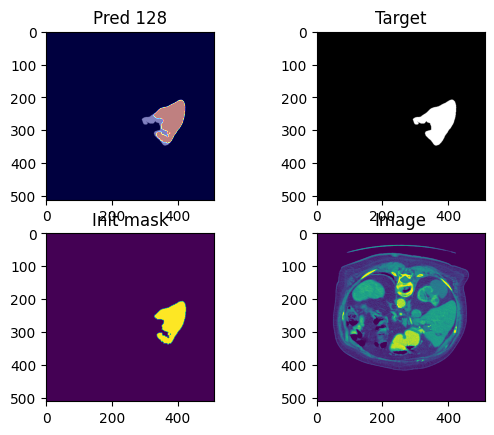

In [44]:
idx = start_idx + 26
target_mask = masks[idx].copy() == 1
img = volumes[idx]
f, axes = plt.subplots(2, 2)
# plt.imshow(Image1, cmap='gray')
target_mask = np.stack([target_mask, target_mask, target_mask]).transpose([1, 2, 0]).astype(np.uint16) * 255
axes[0, 0].imshow(target_mask, interpolation=None)
axes[0, 0].imshow(data[idx - start_idx], cmap='jet', interpolation=None, alpha=0.5)

axes[0, 1].imshow(target_mask)
axes[1, 0].imshow(pred[idx])
axes[1, 1].imshow(img)

axes[0, 0].set_title(f'Pred {idx}')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Init mask')
axes[1, 1].set_title('Image')

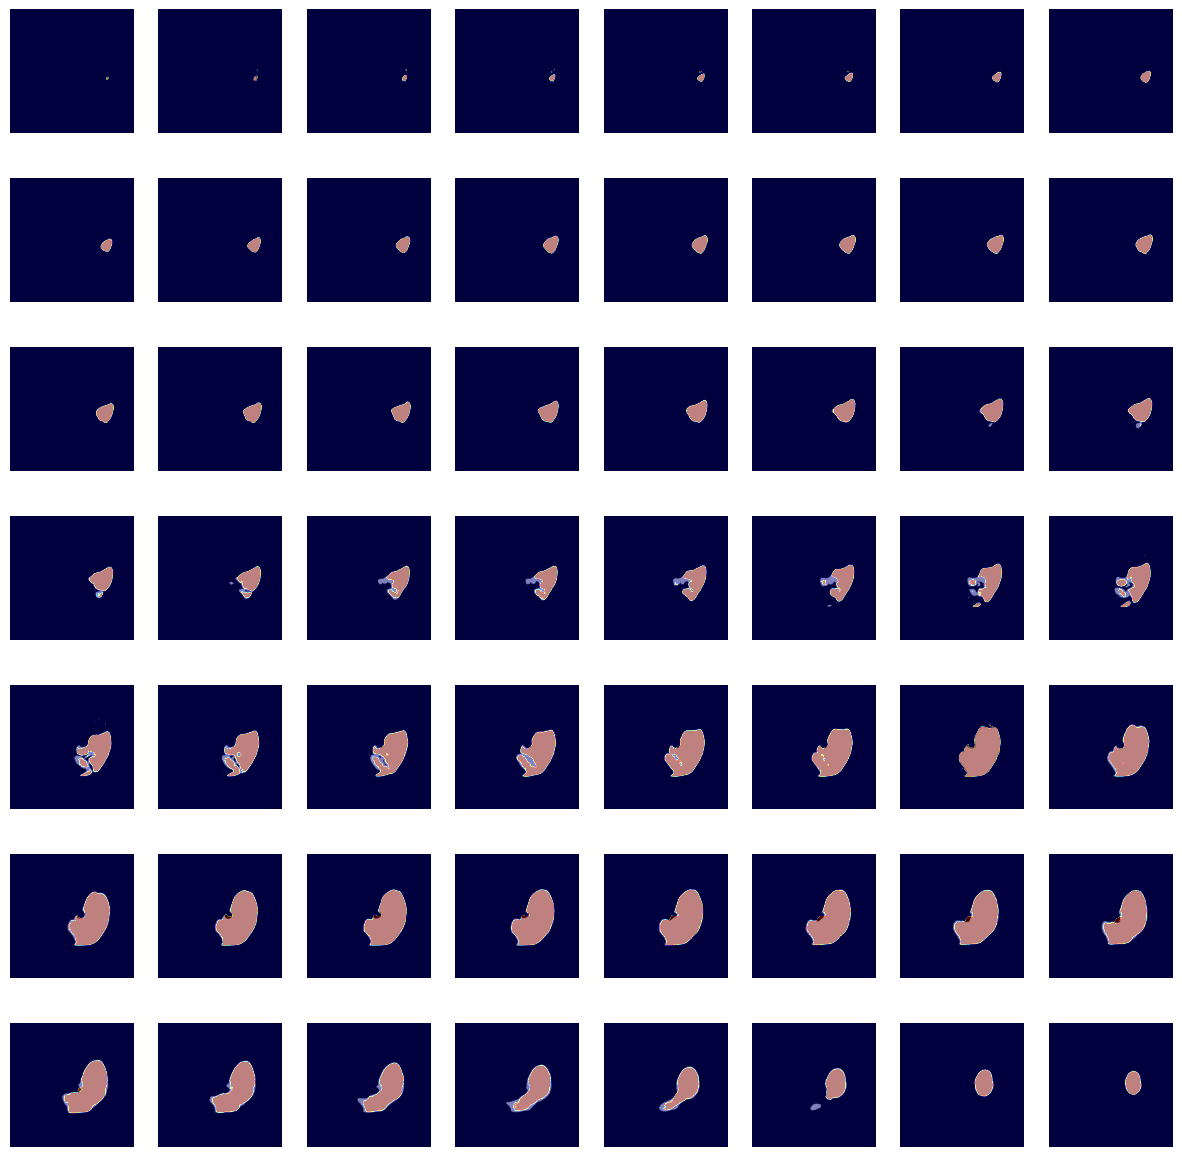

In [45]:
def grid_imshow(data: np.ndarray, start_idx: int):
    l = data.shape[0]
    n_row = int(np.sqrt(l))
    n_col = int(np.ceil(l // n_row))
    f, axes = plt.subplots(n_row, n_col, figsize=(15, 15), squeeze=False)
    for row in range(n_row):
        for col in range(n_col):
            idx = row * n_col + col
            if idx >= l: break
            target_mask = masks[idx + start_idx].copy() == 1
            # img = volumes[idx]
            target_mask = np.stack(
                [target_mask, target_mask, target_mask]).transpose([1, 2, 0]).astype(np.uint16) * 255
            axes[row, col].imshow(target_mask, interpolation=None)
            axes[row, col].imshow(data[idx], cmap='jet', interpolation=None, alpha=0.5)
            axes[row, col].axis('off')
            
            
    plt.show()

grid_imshow(data, start_idx)

In [ ]:
from glob import glob

gt_files = sorted(list(glob(f"{VAL_ROOT}/labels/*nii.gz")))
image_files = sorted(list(glob(f"{VAL_ROOT}/images/*nii.gz")))

In [ ]:
len(gt_files)

In [ ]:
# Only care about the liver
local_mean_centroid = np.zeros((14, 3))
local_mean_centroid[1] = np.array([0.38626369, 0.54490201, 0.67218827])

def make_centroid(masks, local_mean_centroid: np.ndarray):
    # NOTE: Remember to reverse the masks
    starts, ends = get_all_organ_range(masks)
    starts = np.nan_to_num(starts.astype(np.float32), nan=0.0)
    ends = np.nan_to_num(ends.astype(np.float32), nan=0.0)
    dur = ends - starts
    dur: np.ndarray = np.pad(
        np.reshape(dur, [-1, 1]), 
        pad_width=[(0, 0), (0, 2)], 
        constant_values=512
    )
    # Take the centroid in z-axis of local organ, and then add back the starts
    proposal = dur * local_mean_centroid + np.pad(
        np.reshape(starts, [-1, 1]), 
        pad_width=[(0, 0), (0, 2)], 
        constant_values=0.0
    )
    
    return np.ceil(proposal).astype(np.uint16)


In [ ]:
file_idx = 7
volumes, masks = preprocessor.run_with_config(
    image_file=image_files[file_idx],
    gt_file=gt_files[file_idx],
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
volumes, masks = volumes[::-1], masks[::-1]
proposal = make_centroid(masks, local_mean_centroid)
z, y, x = proposal[1].tolist()

plt.imshow(masks[z] == 1.0)
plt.plot(x, y, markersize=10, marker="o")

In [ ]:
is_ins = []
for file_idx in range(0, 20):
    volumes, masks = preprocessor.run_with_config(
        image_file=image_files[file_idx],
        gt_file=gt_files[file_idx],
        config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
    )
    volumes, masks = volumes[::-1], masks[::-1]
    z, y, x = volumes.shape
    x_mean_per, y_mean_per, z_mean_per = (0.6721882690535713, 0.5449020087665863, 0.352355387374095)
    x = int(x * x_mean_per)
    y = int(y * y_mean_per)
    z = int(z * z_mean_per)
    is_in = masks[z, y, x]
    is_ins.append(is_in)
    # plt.imshow(masks[z] == 1.0)
    # plt.plot(x, y, markersize=10, marker="o")

In [ ]:
is_ins

In [ ]:

# for file_idx in range(0, 20):
file_idx = 7
volumes, masks = preprocessor.run_with_config(
    image_file=image_files[file_idx],
    gt_file=gt_files[file_idx],
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
volumes, masks = volumes[::-1], masks[::-1]
z, y, x = volumes.shape
x_mean_per, y_mean_per, z_mean_per = (0.6721882690535713, 0.5449020087665863, 0.352355387374095)
x = int(x * x_mean_per)
y = int(y * y_mean_per)
z = int(z * z_mean_per)
plt.imshow(masks[z])
plt.plot(x, y, markersize=10, marker="o")

In [ ]:
def confidence_score(logits, threshold):
    # Idea: confidence is high when the prob of 
    # foreground high and prob of background is low
    foreground_score = np.mean(logits[logits >= threshold])
    background_score = 1.0 - np.mean(logits[logits < threshold])
    return np.mean([foreground_score, background_score])

sigmoid_mask = tracing_tool[0][-1][-1]

In [ ]:
max(tracing_tool[0], key=lambda x: x[1])

In [ ]:
max(tracing_tool[0], key=lambda x: x[1])[-1]

In [ ]:
sigmoid_masks = torch.sigmoid(sigmoid_mask)
mask_threshold = 0.5
threshold_offset = 0.1
intersections = (
            (sigmoid_masks > (mask_threshold + threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )

unions = (
            (sigmoid_masks > (mask_threshold - threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )
print(intersections, unions)

In [ ]:
confidence_score(logits=torch.sigmoid(sigmoid_mask).numpy(), threshold=0.5)